In [1]:
import tensorflow as tf

2023-09-22 14:05:09.035993: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-22 14:05:09.065052: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-22 14:05:10.151026: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.__version__

'2.13.0'

In [3]:
import glob
# import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
# from tensorflow.python.keras import layers
from tensorflow.keras import layers, activations
import time
import nibabel as nib
from tqdm import tqdm
import gc

from scipy.ndimage import binary_erosion, zoom

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio

from IPython import display
import datetime
import cv2

from data_loader import load_data_dti_only
from sr_utility import space_to_depth, depth_to_space

import model
import data_utils
from Architectures import ESRGAN

In [4]:
e_or_o = 1

p_size_i = 5
p_size_o = 3

# e_or_o = 0

# p_size_i = 8
# p_size_o = 8

# generator = tf.keras.saving.load_model('Model/unet{}x_t1_concat_end'.format(2*p_size_o + e_or_o))

# generator = tf.keras.saving.load_model('Model/espcn{}x_t1_start'.format(2*p_size_o + e_or_o))

# generator = tf.keras.saving.load_model('Model/espcn{}x_t1_end'.format(2*p_size_o + e_or_o))


# generator = tf.keras.saving.load_model('Model/espcn{}x_baseline_t1_start'.format(2*p_size_o + e_or_o))

# generator = tf.keras.saving.load_model('Model/espcn{}x_baseline_t1_start'.format(2*p_size_o + e_or_o))
# generator = tf.keras.saving.load_model('Model/espcn{}x_baseline_t2_end'.format(2*p_size_o + e_or_o))


# generator = tf.keras.saving.load_model('Model/espcn{}x_GAN_t1_start'.format(2*p_size_o + e_or_o))

# generator = tf.keras.saving.load_model('Model/esrgan_t1')

generator = tf.keras.saving.load_model('Model/espcn{}x_baseline'.format(2*p_size_o + e_or_o))

# e_or_o = 0

# p_size_i = 8
# p_size_o = 8


# generator = tf.keras.saving.load_model('Model/generator{}x_t2_concat_end'.format(2*p_size_o + e_or_o))

# generator = tf.keras.saving.load_model('Model/unet{}x_not1'.format(2*p_size_o + e_or_o))

2023-09-22 14:05:12.752408: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-22 14:05:12.768464: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-22 14:05:12.768593: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
generator.inputs[0].shape, generator.outputs[0].shape

(TensorShape([None, 11, 11, 11, 6]), TensorShape([None, 14, 14, 14, 6]))

In [6]:
subj = '163129'


subjects_lr, subjects_t1, subjects_hr, subjects_masks, [transform_lr, transform_hr] = load_data_dti_only("../HCPData/Test", [subj], pads = [(8+16, 7+16), (9+8, 9+8), (8+16, 7+16), (0,0)])

lowres_input = subjects_lr[0]
t1_input = subjects_t1[0]
hires_input = subjects_hr[0]
mask_input = subjects_masks[0]


Loading Subject 163129


In [7]:
print(lowres_input.shape)
print(lowres_input[::2,::2,::2,:].shape)
print(t1_input.shape)

(192, 208, 192, 6)
(96, 104, 96, 6)
(192, 208, 192, 8)


In [8]:
np.unique(mask_input)

array([0., 1.])

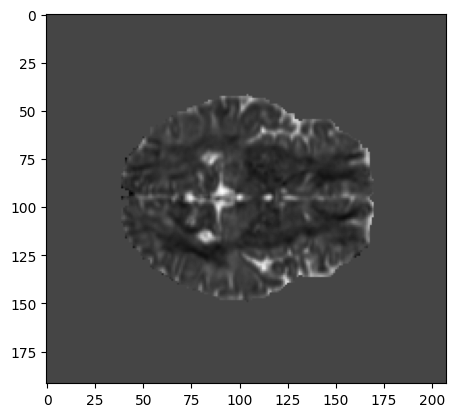

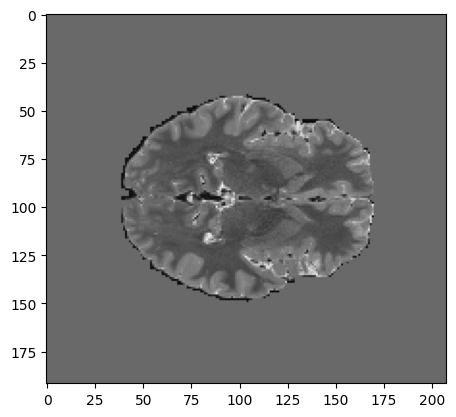

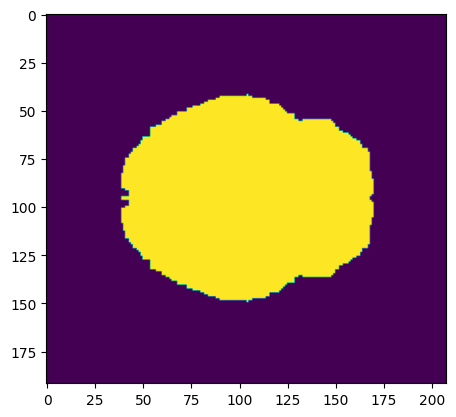

In [9]:
plt.imshow(lowres_input[:,:,80,0], cmap='gray')
plt.figure()
plt.imshow(t1_input[:,:,80,0], cmap='gray')
plt.figure()

plt.imshow(mask_input[:,:,80])

In [10]:
# generator_nopatch = None

# generator_nopatch = ESRGAN.srgan_gen_multmode(ishape = [lowres_input.shape[0]//2+8, lowres_input.shape[1]//2, lowres_input.shape[2]//2+8, lowres_input.shape[3]],
#                                               ishape_t1 = [t1_input.shape[0]+16, t1_input.shape[1], t1_input.shape[2]+16, t1_input.shape[3]])

In [11]:
# generator_nopatch.inputs[0].shape, generator_nopatch.outputs[0].shape

In [12]:
# generator_nopatch.summary()

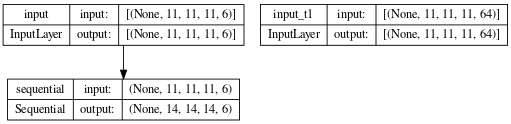

In [13]:
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [14]:
s = 6

lowres_input_ds = lowres_input[::2,::2,::2,:]

(xsize, ysize, zsize, comp) = lowres_input_ds.shape

print(xsize * 2, ysize * 2, zsize * 2)

result_image = np.zeros((xsize*2, ysize*2, zsize*2, comp))
result_image_2 = np.zeros((xsize*2, ysize*2, zsize*2, comp))

# result_image = np.zeros((xsize, ysize, zsize, comp))

# recon_indx = [(i, j, k) for k in np.arange(p_size_i+e_or_o,
#                                            zsize-p_size_i+e_or_o,
#                                            2*p_size_o+e_or_o-4)
#                         for j in np.arange(p_size_i+e_or_o,
#                                            ysize-p_size_i+e_or_o,
#                                            2*p_size_o+e_or_o-4)
#                         for i in np.arange(p_size_i+e_or_o,
#                                            xsize-p_size_i+e_or_o,
#                                            2*p_size_o+e_or_o-4)]

recon_indx = [(i, j, k) for k in np.arange(p_size_i+e_or_o,
                                           zsize-p_size_i+e_or_o,
                                           2*p_size_o+e_or_o)
                        for j in np.arange(p_size_i+e_or_o,
                                           ysize-p_size_i+e_or_o,
                                           2*p_size_o+e_or_o)
                        for i in np.arange(p_size_i+e_or_o,
                                           xsize-p_size_i+e_or_o,
                                           2*p_size_o+e_or_o)]

for (i, j, k) in tqdm(recon_indx):

    if (i - p_size_i < 0 or j - p_size_i < 0 or k - p_size_i < 0):
        continue

    if (i + p_size_i >= xsize or j + p_size_i >= ysize or k + p_size_i >= zsize):
        continue

    if np.max(mask_input[::2,::2,::2][i - p_size_i : i + p_size_i,
                                      j - p_size_i : j + p_size_i,
                                      k - p_size_i : k + p_size_i]) != 1:
        continue

    lr_patch_samp = np.zeros((2 * p_size_i + e_or_o, 2 * p_size_i + e_or_o, 2 * p_size_i + e_or_o, 70))

    lr_patch =  np.copy(lowres_input_ds)[
                        i - p_size_i : i + p_size_i + e_or_o,
                        j - p_size_i : j + p_size_i + e_or_o,
                        k - p_size_i : k + p_size_i + e_or_o,:]

    t1_patch =  t1_input[
                        2*(i - p_size_i - e_or_o) : 2*(i + p_size_i),
                        2*(j - p_size_i - e_or_o) : 2*(j + p_size_i),
                        2*(k - p_size_i - e_or_o) : 2*(k + p_size_i),:]

    # t1_patch = np.random.randn(2*p_size_i + 2*(p_size_i + e_or_o), 2*p_size_i + 2*(p_size_i + e_or_o), 2*p_size_i + 2*(p_size_i + e_or_o), 8)

    # lr_patch_samp[...,:6] = lr_patch

    # lr_patch_samp[...,6:] = space_to_depth(t1_patch)

    # lr_patch = lr_patch_samp
    

    output_patch = generator([lr_patch[None,...], space_to_depth(t1_patch)[None,...]], training=False)

    # output_patch = generator([lr_patch[None,...], t1_patch[None,...]], training=False)

    # print(depth_to_space(output_patch, upsampling_rate=2).shape)

    # result_image[2*(i - p_size_o - e_or_o)+2 : 2*(i + p_size_o)-2,
    #              2*(j - p_size_o - e_or_o)+2 : 2*(j + p_size_o)-2,
    #              2*(k - p_size_o - e_or_o)+2 : 2*(k + p_size_o)-2, :] = output_patch[0,2:-2,2:-2,2:-2,:]


    # print(output_patch)

    result_image[2*(i - p_size_o) : 2*(i + p_size_o + e_or_o),
                 2*(j - p_size_o) : 2*(j + p_size_o + e_or_o),
                 2*(k - p_size_o) : 2*(k + p_size_o + e_or_o), :] = (output_patch[0,:,:,:,:])

    # result_image[2*(i - p_size_o+2) : 2*(i + p_size_o + e_or_o-2),
    #              2*(j - p_size_o+2) : 2*(j + p_size_o + e_or_o-2),
    #              2*(k - p_size_o+2) : 2*(k + p_size_o + e_or_o-2), :] = (output_patch[0,4:-4,4:-4,4:-4,:])

    # lr_patch = lr_patch + 0.1*np.random.randn(lr_patch.shape[0], lr_patch.shape[1], lr_patch.shape[2], lr_patch.shape[3])

    lr_patch = 0 * lr_patch
    
    # t1_patch = np.zeros((2*p_size_i + 2*(p_size_i + e_or_o), 
    #                      2*p_size_i + 2*(p_size_i + e_or_o), 
    #                      2*p_size_i + 2*(p_size_i + e_or_o), 8))

    # t1_patch = np.random.randn(t1_patch.shape[0], t1_patch.shape[1], t1_patch.shape[2], t1_patch.shape[3])

    output_patch = generator([lr_patch[None,...], space_to_depth(t1_patch)[None,...]], training=False)
    
    # output_patch = generator([lr_patch[None,...], t1_patch[None,...]], training=False)
    
    result_image_2[2*(i - p_size_o) : 2*(i + p_size_o + e_or_o),
                 2*(j - p_size_o) : 2*(j + p_size_o + e_or_o),
                 2*(k - p_size_o) : 2*(k + p_size_o + e_or_o), :] = (output_patch[0,:,:,:,:])

    # result_image_2[
    #                 2*(i - p_size_o+2) : 2*(i + p_size_o + e_or_o-2),
    #                 2*(j - p_size_o+2) : 2*(j + p_size_o + e_or_o-2),
    #                 2*(k - p_size_o+2) : 2*(k + p_size_o + e_or_o-2), :] = (output_patch[0,4:-4,4:-4,4:-4,:])

result_image[mask_input == 0] = 0
result_image_2[mask_input == 0] = 0
    

192 208 192


  0%|                                                  | 0/2366 [00:00<?, ?it/s]2023-09-22 13:21:55.148186: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-22 13:21:55.585744: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
100%|██████████████████████████████████████| 2366/2366 [00:12<00:00, 185.07it/s]


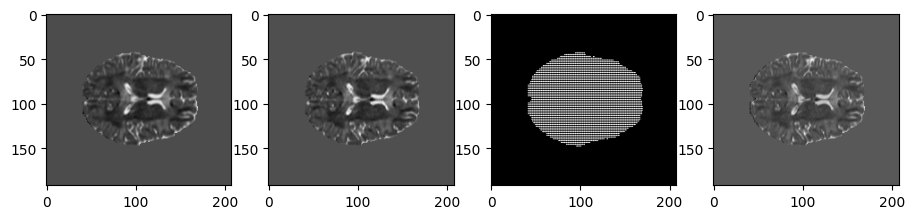

In [15]:
zdim = 90
channel = 0

# plt.imshow(lowres_input[:,:,zdim,channel], cmap='gray')
# plt.figure()
# plt.imshow(hires_output[:,:,zdim,channel], cmap='gray')
# plt.figure()
# plt.imshow(result_image[:,:,zdim,channel], cmap='gray')

fig = plt.figure(figsize=(11,16))

fig.add_subplot(1,4,1)
plt.imshow(lowres_input[:,:,zdim,channel], cmap='gray')#,vmax=2)
fig.add_subplot(1,4,2)
plt.imshow(result_image[:,:,zdim,channel], cmap='gray')
fig.add_subplot(1,4,3)
plt.imshow(result_image_2[:,:,zdim,channel], cmap='gray')
fig.add_subplot(1,4,4)
plt.imshow(hires_input[:,:,zdim,channel], cmap='gray')

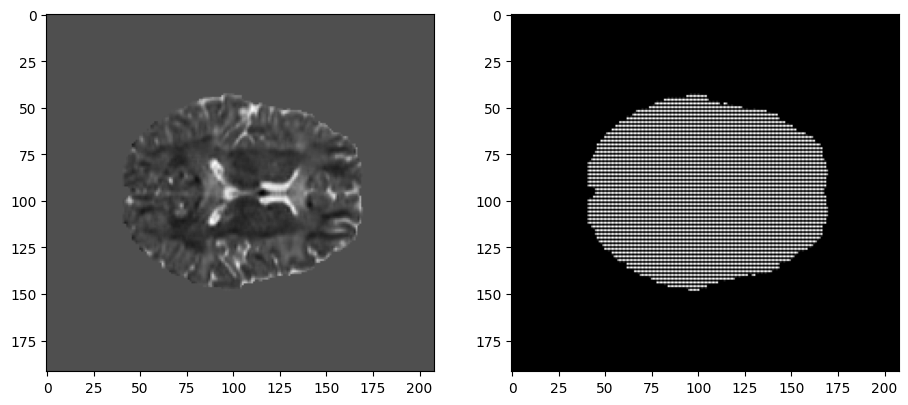

In [16]:
fig = plt.figure(figsize=(11,16))

fig.add_subplot(1,2,1)
plt.imshow(result_image[:,:,zdim,channel], cmap='gray')
fig.add_subplot(1,2,2)
plt.imshow(result_image_2[:,:,zdim,channel], cmap='gray')

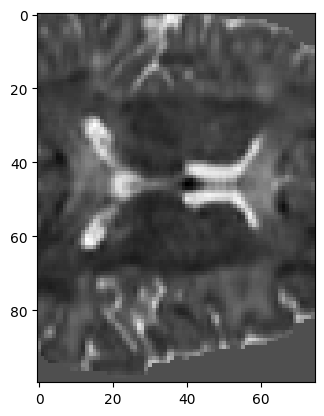

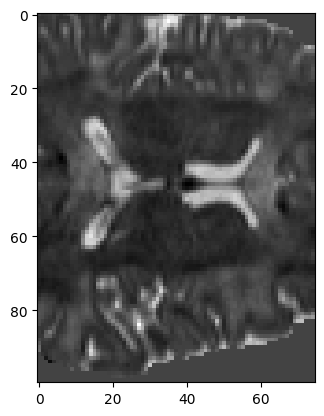

In [17]:
zdim = 90
channel = 0

plt.imshow(result_image[50:150,75:150,zdim,channel], cmap='gray')
plt.figure()
plt.imshow(hires_input[50:150,75:150,zdim,channel], cmap='gray')

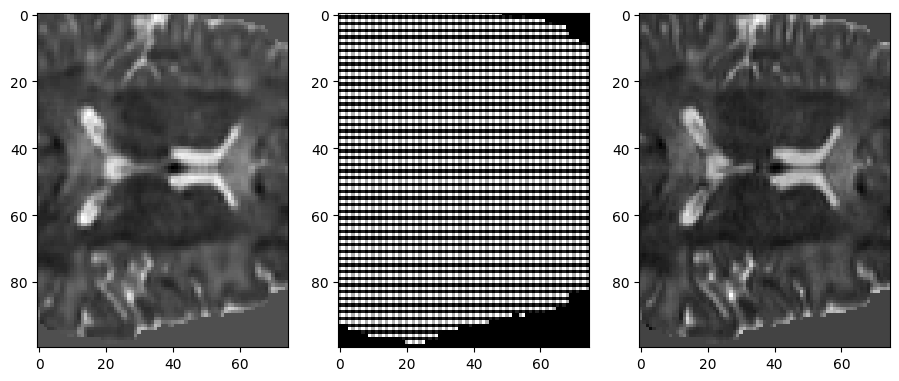

In [18]:
fig = plt.figure(figsize=(11,16))

fig.add_subplot(1,3,1)
plt.imshow(result_image[50:150,75:150,zdim,channel], cmap='gray')
fig.add_subplot(1,3,2)
plt.imshow(result_image_2[50:150,75:150,zdim,channel], cmap='gray')
fig.add_subplot(1,3,3)
plt.imshow(hires_input[50:150,75:150,zdim,channel], cmap='gray')

In [19]:
print(np.mean(np.square(result_image - result_image_2)))

print(np.mean(np.square(result_image - hires_input)))

print(np.mean(np.square(hires_input - result_image_2)))

0.07706943812226567
0.010299825455846883
0.09020220519797156


In [20]:
print(np.max(result_image[:,:,:,:]))
print(np.max(hires_input[:,:,:,:]))
print(np.max(lowres_input[:,:,:,:]))

7.168996334075928
7.740401957586106
7.728448528289702


In [21]:
lr_act = np.pad(subjects_lr[0], ((0,0), (0,0), (0,0), (2,0)), mode='constant')
hr_act = np.pad(subjects_hr[0], ((0,0), (0,0), (0,0), (2,0)), mode='constant')
hr_pred = np.pad(result_image, ((0,0), (0,0), (0,0), (2,0)), mode='constant')
hr_pred_2 = np.pad(result_image, ((0,0), (0,0), (0,0), (2,0)), mode='constant')


for ch in range(2,8):
    # lr_act[...,ch] = zoom(lowres_input[::2,::2,::2,ch-2], 2) * transform_lr[0][ch-2,1] + transform_lr[0][ch-2,0]
    # lr_act[mask_input == 0] = 0
    # hr_act[...,ch] = hires_input[...,ch-2] * transform_hr[0][ch-2,1] + transform_hr[0][ch-2,0]
    # hr_act[mask_input == 0] = 0
    # hr_pred[...,ch] = result_image[...,ch-2] * transform_lr[0][ch-2,1] + transform_lr[0][ch-2,0]
    # hr_pred[mask_input == 0] = 0

    # lr_act[...,ch] = zoom(lowres_input[::2,::2,::2,ch-2], 2) * transform_lr[0][ch-2,1] + transform_lr[0][ch-2,0]
    # lr_act[binary_erosion(mask_input, structure=np.ones((5,5,5),np.uint8),iterations = 1) == 0] = 0
    # hr_act[...,ch] = hires_input[...,ch-2] * transform_hr[0][ch-2,1] + transform_hr[0][ch-2,0]
    # hr_act[binary_erosion(mask_input, structure=np.ones((5,5,5),np.uint8),iterations = 1) == 0] = 0
    # hr_pred[...,ch] = result_image[...,ch-2] * transform_lr[0][ch-2,1] + transform_lr[0][ch-2,0]
    # hr_pred[binary_erosion(mask_input, structure=np.ones((5,5,5),np.uint8),iterations = 1) == 0] = 0

    lr_act[...,ch] = zoom(lowres_input[::2,::2,::2,ch-2], 2) * transform_lr[0][ch-2,1] + transform_lr[0][ch-2,0]
    lr_act[mask_input == 0] = 0
    hr_act[...,ch] = hires_input[...,ch-2] * transform_hr[0][ch-2,1] + transform_hr[0][ch-2,0]
    hr_act[mask_input == 0] = 0
    hr_pred[...,ch] = result_image[...,ch-2] * transform_lr[0][ch-2,1] + transform_lr[0][ch-2,0]
    hr_pred[mask_input == 0] = 0

    hr_pred_2[...,ch] = result_image_2[...,ch-2] * transform_lr[0][ch-2,1] + transform_lr[0][ch-2,0]
    hr_pred_2[mask_input == 0] = 0



In [22]:
[XSIZE, YSIZE, ZSIZE, dim] = hr_act.shape


md_lr_i, fa_lr_i, cfa_lr_i = data_utils.calc_MD_FA_CFA(lr_act[::2,::2,::2,:], XSIZE//2, YSIZE//2, ZSIZE//2)
md_lr, fa_lr, cfa_lr = data_utils.calc_MD_FA_CFA(lr_act, XSIZE, YSIZE, ZSIZE)
md_hr, fa_hr, cfa_hr = data_utils.calc_MD_FA_CFA(hr_act, XSIZE, YSIZE, ZSIZE)
md_gen, fa_gen, cfa_gen = data_utils.calc_MD_FA_CFA(hr_pred, XSIZE, YSIZE, ZSIZE)
md_gen_2, fa_gen_2, cfa_gen_2 = data_utils.calc_MD_FA_CFA(hr_pred_2, XSIZE, YSIZE, ZSIZE)

100%|█████████████████████████████████████████| 192/192 [00:28<00:00,  6.67it/s]


0.9226109366356374
0.0


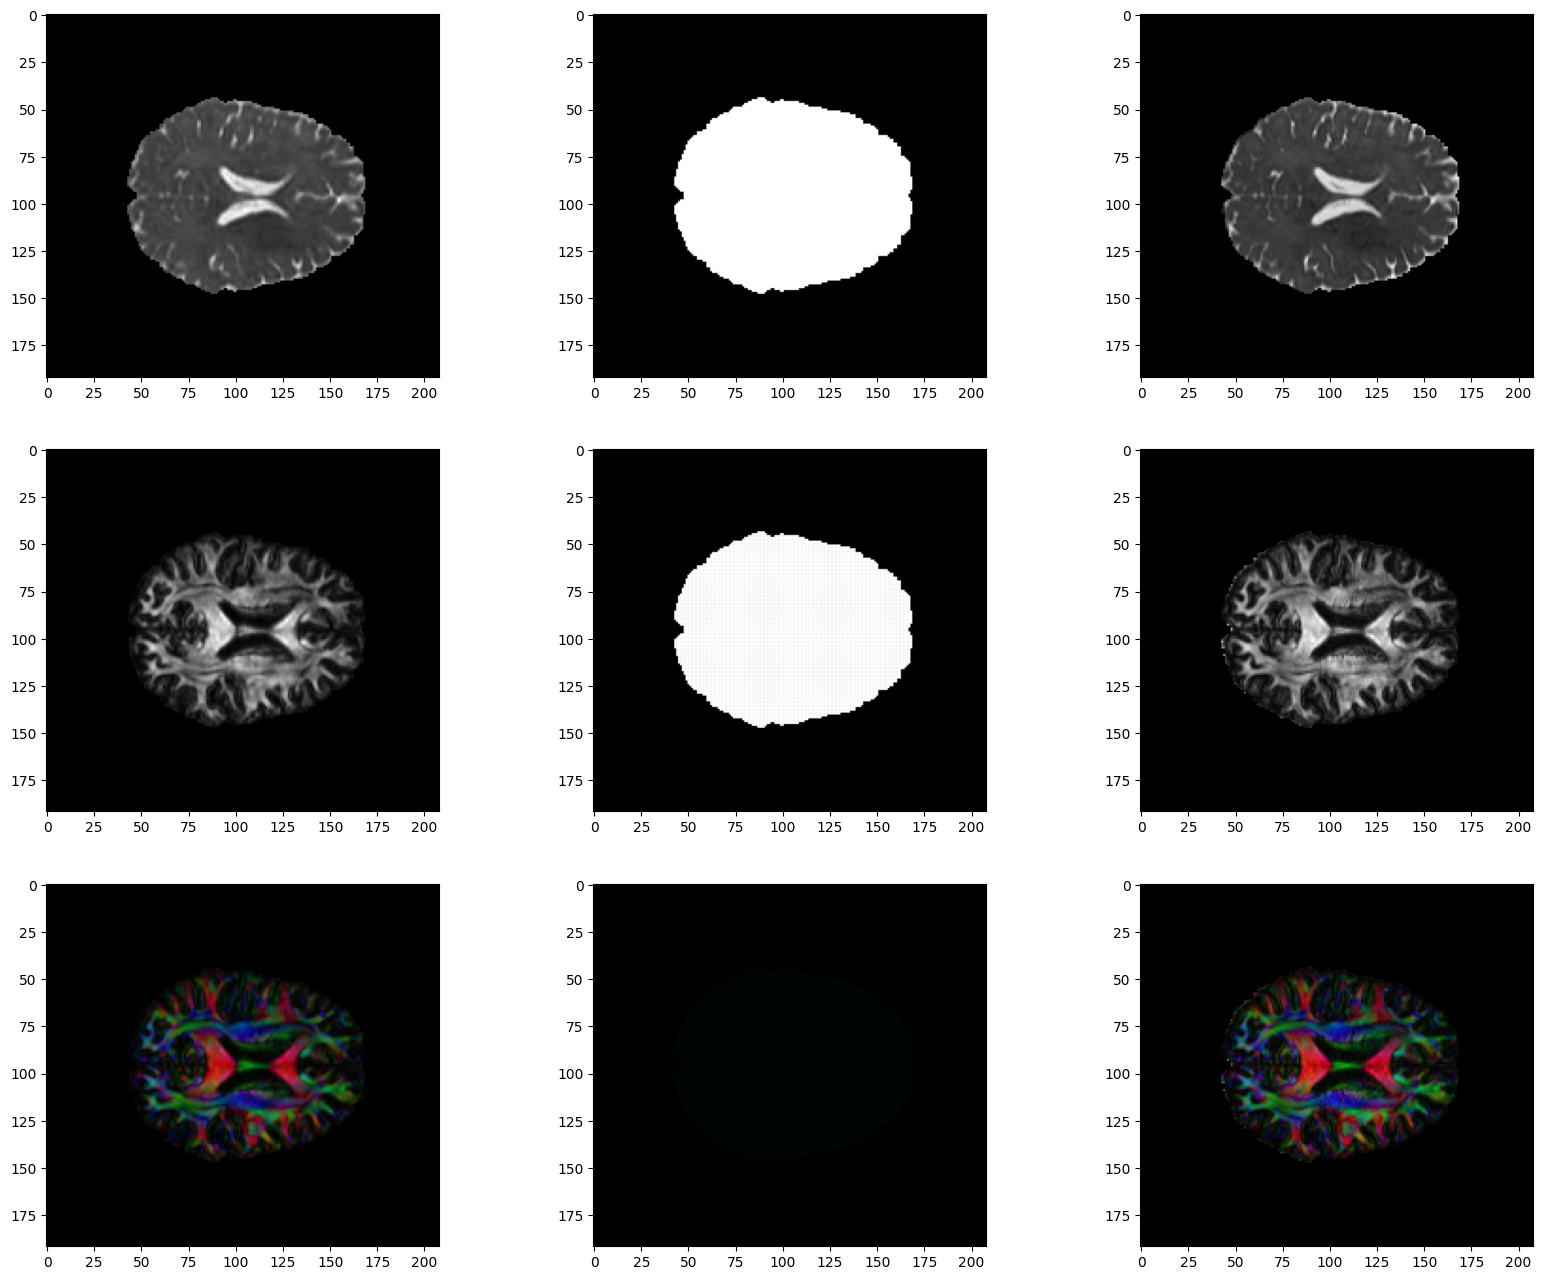

In [23]:
zdim = 95

fig = plt.figure(figsize=(20,16))


fig.add_subplot(3,3,1)
plt.imshow(md_gen[:,:,zdim], cmap='gray')
fig.add_subplot(3,3,2)
plt.imshow(md_gen_2[:,:,zdim], cmap='gray')
fig.add_subplot(3,3,3)
plt.imshow(md_hr[:,:,zdim], cmap='gray')

print(np.max(fa_gen[:,:,zdim]))
print(np.min(cfa_gen_2[:,:,zdim,2]))

fig.add_subplot(3,3,4)
plt.imshow(fa_gen[:,:,zdim], cmap='gray')
fig.add_subplot(3,3,5)
plt.imshow(fa_gen_2[:,:,zdim], cmap='gray')
fig.add_subplot(3,3,6)
plt.imshow(fa_hr[:,:,zdim], cmap='gray')


fig.add_subplot(3,3,7)
plt.imshow(cfa_gen[:,:,zdim], vmax=1)
fig.add_subplot(3,3,8)
plt.imshow(cfa_gen_2[:,:,zdim])
fig.add_subplot(3,3,9)
plt.imshow(cfa_hr[:,:,zdim], vmax=1)

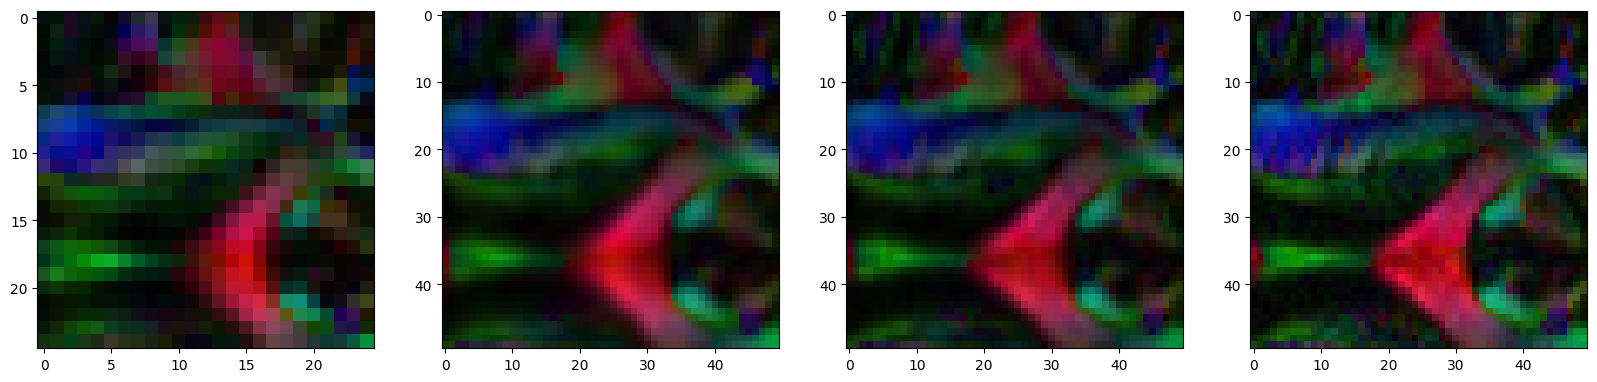

In [24]:
fig = plt.figure(figsize=(20,16))

fig.add_subplot(1,4,1)
plt.imshow(cfa_lr_i[30:55,50:75,zdim//2], cmap='gray')
fig.add_subplot(1,4,2)
plt.imshow(cfa_lr[60:110,100:150,zdim], cmap='gray')
fig.add_subplot(1,4,3)
plt.imshow(cfa_gen[60:110,100:150,zdim], cmap='gray')
fig.add_subplot(1,4,4)
plt.imshow(cfa_hr[60:110,100:150,zdim], cmap='gray')

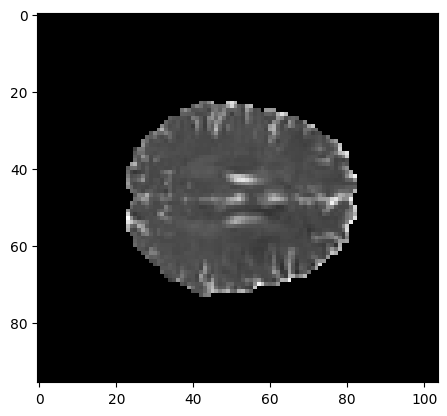

In [25]:
from scipy.io import savemat

plt.imshow(md_lr_i[:,:,50], cmap='gray')

savemat("./MD_hcp.mat", {'MD': md_lr_i})

In [26]:
print(XSIZE, YSIZE, ZSIZE)

192 208 192


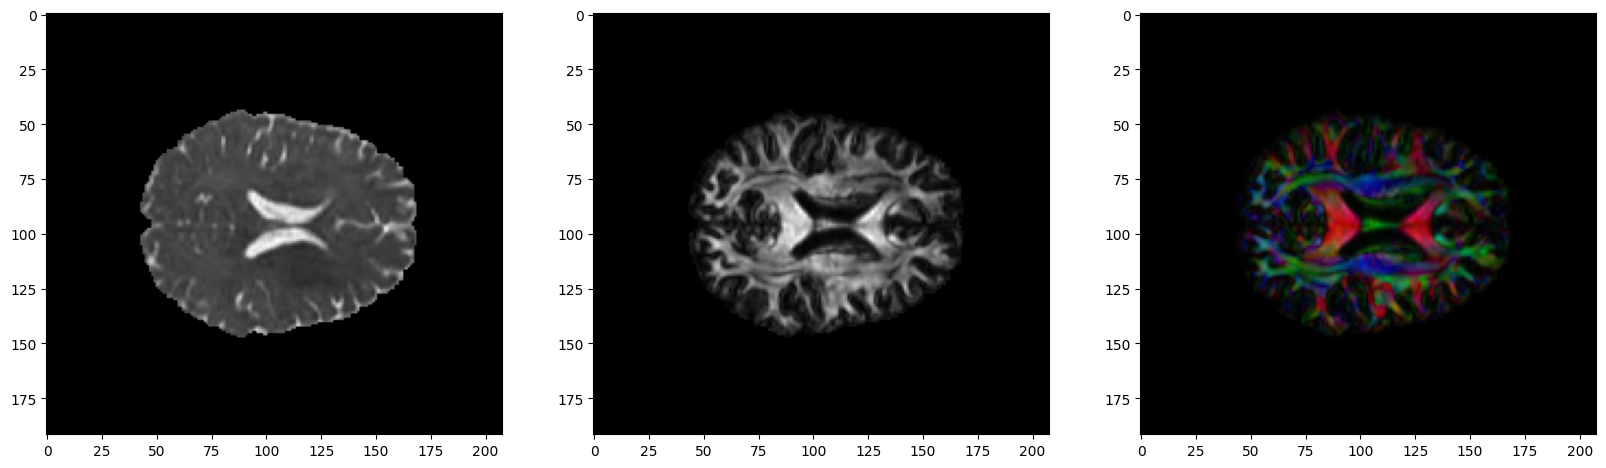

In [27]:
fig = plt.figure(figsize=(20,16))


fig.add_subplot(1,3,1)
plt.imshow(md_gen[:,:,zdim], cmap='gray')
fig.add_subplot(1,3,2)
plt.imshow(fa_gen[:,:,zdim], cmap='gray')
fig.add_subplot(1,3,3)
plt.imshow(cfa_gen[:,:,zdim], vmax=1)

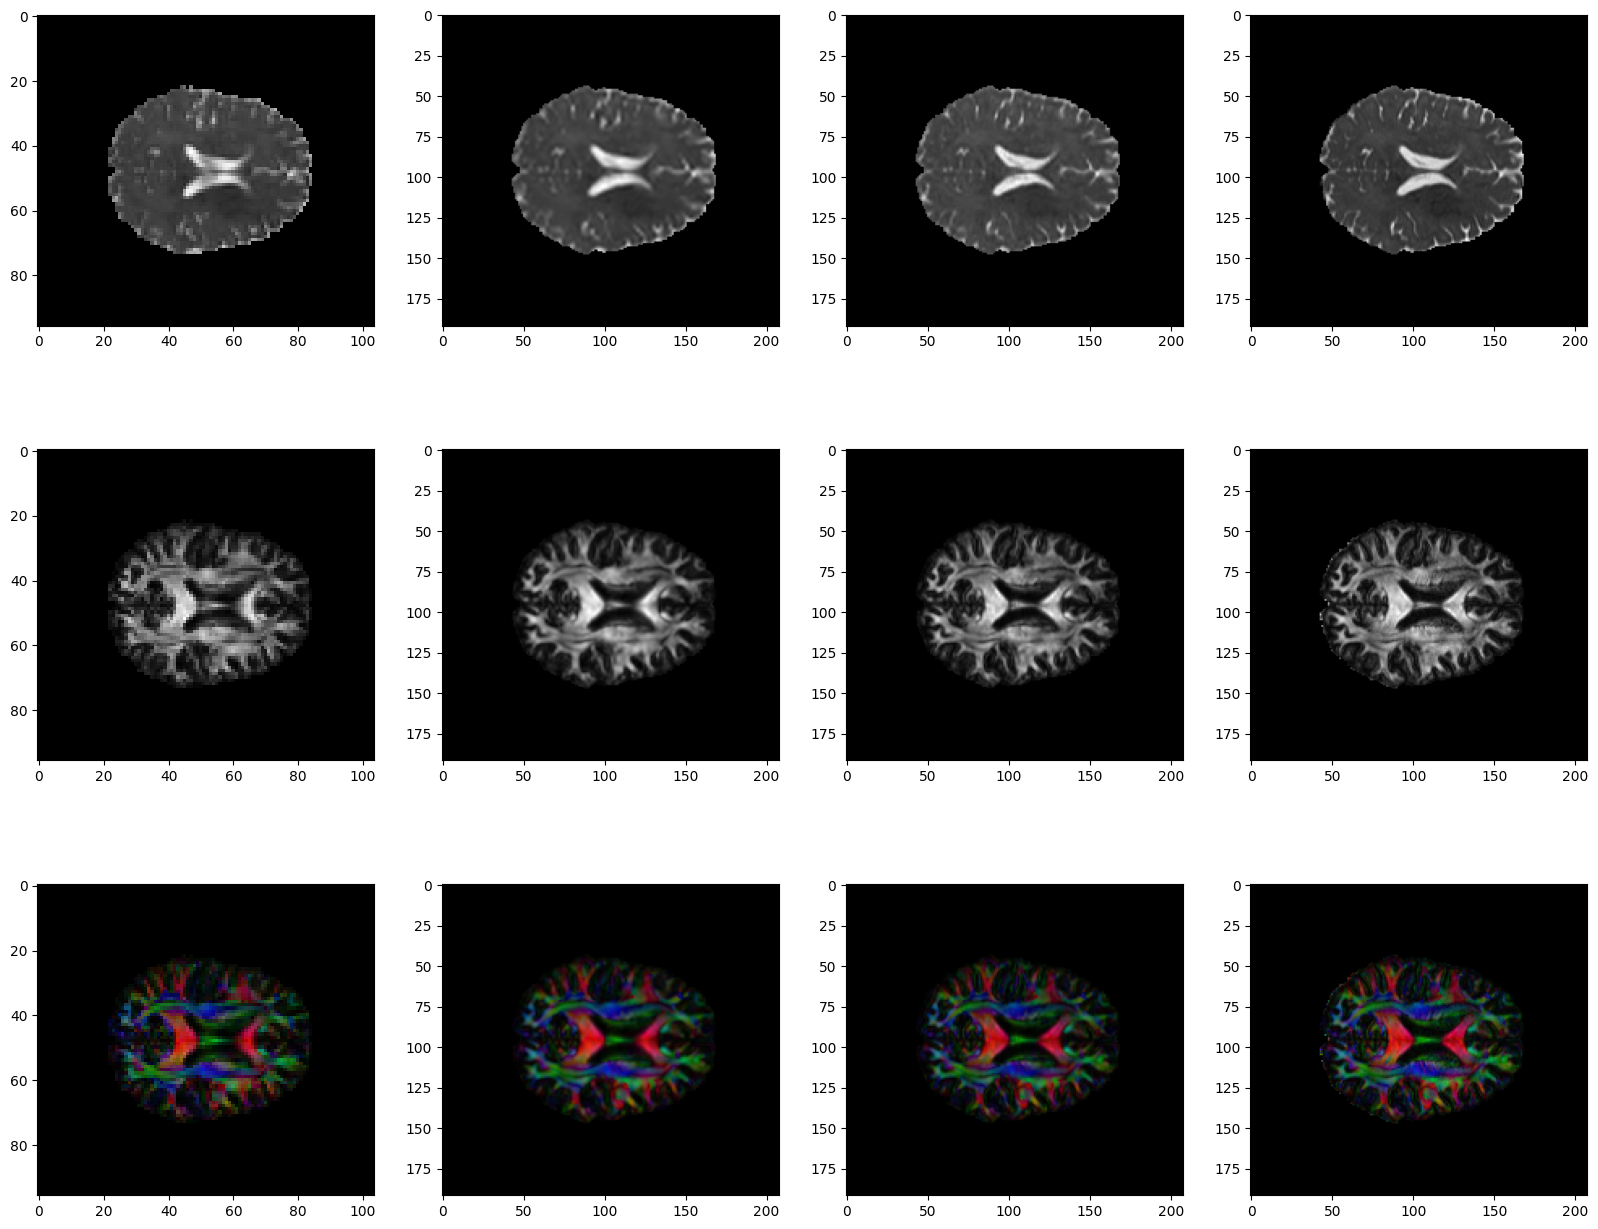

In [28]:
zdim = 95

fig = plt.figure(figsize=(20,16))

fig.add_subplot(3,4,1)
plt.imshow(md_lr_i[:,:,zdim//2], cmap='gray')
fig.add_subplot(3,4,2)
plt.imshow(md_lr[:,:,zdim], cmap='gray')
fig.add_subplot(3,4,3)
plt.imshow(md_gen[:,:,zdim], cmap='gray')
fig.add_subplot(3,4,4)
plt.imshow(md_hr[:,:,zdim], cmap='gray')

fig.add_subplot(3,4,5)
plt.imshow(fa_lr_i[:,:,zdim//2], cmap='gray')
fig.add_subplot(3,4,6)
plt.imshow(fa_lr[:,:,zdim], cmap='gray')
fig.add_subplot(3,4,7)
plt.imshow(fa_gen[:,:,zdim], cmap='gray')
fig.add_subplot(3,4,8)
plt.imshow(fa_hr[:,:,zdim], cmap='gray')

fig.add_subplot(3,4,9)
plt.imshow(cfa_lr_i[:,:,zdim//2], cmap='gray')
fig.add_subplot(3,4,10)
plt.imshow(cfa_lr[:,:,zdim], vmax=1)
fig.add_subplot(3,4,11)
plt.imshow(cfa_gen[:,:,zdim], vmax=1)
fig.add_subplot(3,4,12)
plt.imshow(cfa_hr[:,:,zdim], vmax=1)

In [29]:
print(ssim(md_hr[:,:,:], md_lr[:,:,:], data_range=np.max(md_hr) - np.min(md_hr)))
print(ssim(md_hr[:,:,:], md_gen[:,:,:], data_range=np.max(md_hr) - np.min(md_hr)))

print(ssim(fa_hr[:,:,:], fa_lr[:,:,:], data_range=np.max(fa_hr) - np.min(fa_hr)))
print(ssim(fa_hr[:,:,:], fa_gen[:,:,:], data_range=np.max(fa_hr) - np.min(fa_hr)))

# print(np.mean(np.square(md_hr[:,:,:] - md_lr[:,:,:])))
# print(np.mean(np.square(md_hr[:,:,:] - md_gen[:,:,:])))

# print(np.mean(np.square(fa_hr[:,:,:] - fa_lr[:,:,:])))
# print(np.mean(np.square(fa_hr[:,:,:] - fa_gen[:,:,:])))

0.9859642474333533
0.9891699546255018
0.9765043040379194
0.9788310337565893


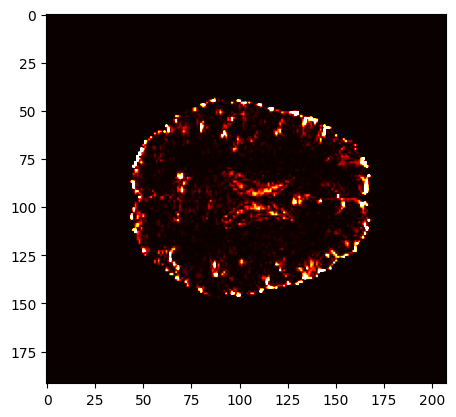

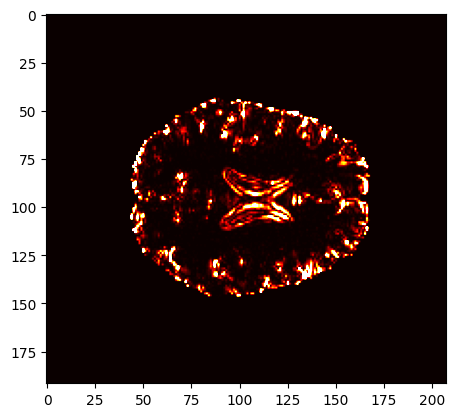

In [30]:
plt.imshow(np.square(md_hr[:,:,96] - md_gen[:,:,96]), 
           vmin=0,
           vmax=np.percentile(np.square(md_hr[:,:,96] - md_lr[:,:,96]), 99), cmap='hot')
plt.figure()
plt.imshow(np.square(md_hr[:,:,96] - md_lr[:,:,96]), 
           vmin=0,
           vmax=np.percentile(np.square(md_hr[:,:,96] - md_lr[:,:,96]), 99), cmap='hot')

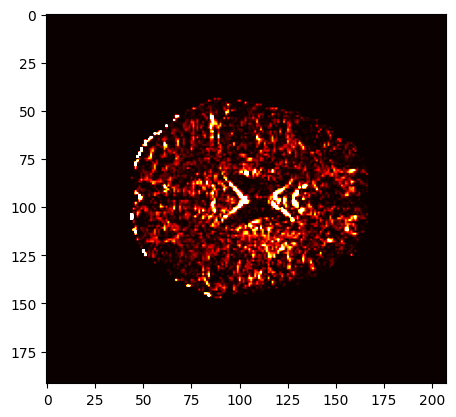

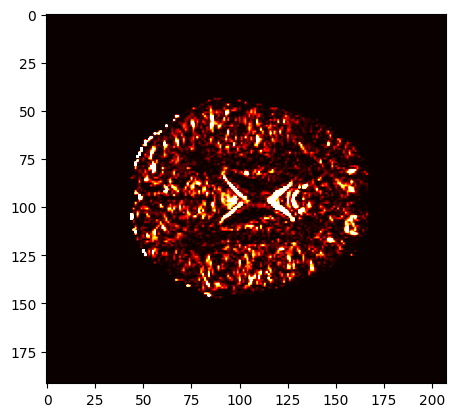

In [31]:
plt.imshow(np.square(fa_hr[:,:,96] - fa_gen[:,:,96]), 
           vmin=0,
           vmax=np.percentile(np.square(fa_hr[:,:,96] - fa_lr[:,:,96]), 99), cmap='hot')
plt.figure()
plt.imshow(np.square(fa_hr[:,:,96] - fa_lr[:,:,96]), 
           vmin=0,
           vmax=np.percentile(np.square(fa_hr[:,:,96] - fa_lr[:,:,96]), 99), cmap='hot')